In [ ]:
import torch
from torch.optim import Adam

import pickle
import soundfile as sf
import IPython.display as ipd

from constants import *
from train import train_model
from early_stopper import EarlyStopper

from phase_loss import PhaseLoss
from magnitude_loss import MagnitudeLoss

from polar_dataset import build_data_loaders
from disk_utils import save_model, load_model
from plotter import plot_loss, plot_heatmaps, plot_waves
from predict import predict_polar, get_phases, make_wav

from models.model_2 import Model_2

In [2]:
USE_GPU = True

num_epochs = 250
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not USE_GPU:
    device = torch.device("cpu")
    num_epochs = 1

In [ ]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

model = Model_2(1, 1, 16)

part = "magnitude"
train_data_loader, test_data_loader = build_data_loaders(
    min_max, part=part, test_size=test_size)

criterion = MagnitudeLoss(
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part]
)
optimizer = Adam(model.parameters(), lr=3e-4)
es = EarlyStopper(7, 3e-6)

In [4]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    device,
    train_data_loader, test_data_loader,
    es,
    num_epochs=num_epochs
)

Starting training...
E: 001/250	 T: 20.494450	 V: 15.736654
E: 002/250	 T: 14.046060	 V: 21.144554
E: 003/250	 T: 12.199410	 V: 16.717722
E: 004/250	 T: 10.802893	 V: 16.693067
E: 005/250	 T: 9.981160	 V: 16.614217
E: 006/250	 T: 9.416917	 V: 16.340646
E: 007/250	 T: 9.138535	 V: 17.521862
E: 008/250	 T: 8.908987	 V: 16.747746
Stopping early...


In [5]:
model.to(torch.device("cpu"))

Model_2(
  (encoder1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
del model
torch.cuda.empty_cache()

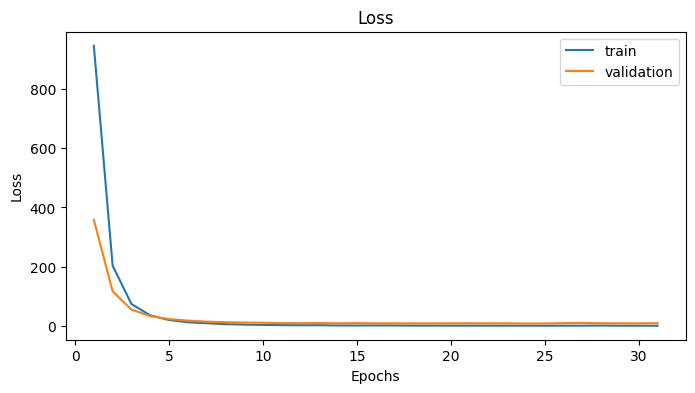

In [6]:
plot_loss(history, "Loss", start=0)

In [ ]:
model = load_model("model_19_mag")

In [ ]:
pred_limit = 32
predictions, targets = predict_polar(
    model,
    test_data_loader,
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part],
    limit=pred_limit,
    to_power=False)

08_Gtr_Gs_3/chunk_0, 08_Gtr_Gs_3/chunk_1, 08_Gtr_Gs_3/chunk_2, 08_Gtr_Gs_3/chunk_3
08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Gtr_Gs_3/chunk_4, 08_Gtr_Gs_3/chunk_5, 08_Gtr_Gs_3/chunk_6, 08_Gtr_Gs_3/chunk_7
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7


--------------------------------------------------
08_Gtr_Gs_3/chunk_8, 08_Gtr_Gs_3/chunk_9, 08_Gtr_Gs_3/chunk_10, 08_Gtr_Gs_3/chunk_11
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Gtr_Gs_3/chunk_12, 08_Gtr_Gs_3/chunk_13, 08_Gtr_Gs_3/chunk_14, 08_Gtr_Gs_3/chunk_15
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Gtr_Gs_3/chunk_16, 08_Gtr_Gs_3/chunk_17, 08_Gtr_Gs_3/chunk_18, 08_Gtr_Gs_3/chunk_19
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Gtr_Gs_3/chunk_20, 08_Gtr_Gs_3/chunk_21, 08_Gtr_Gs_3/chunk_22, 08_Gtr_Gs_3/chunk_23
08_Ney_Gs_3/chunk_20, 08_Ney_Gs_3/chunk_21, 08_Ney_Gs_3/chunk_22, 08_Ney_Gs_3/chunk_23
--------------------------------------------------
08_Gtr_Gs_3/chunk_24, 08_Gtr_Gs_3/chunk_25, 08_Gtr_Gs

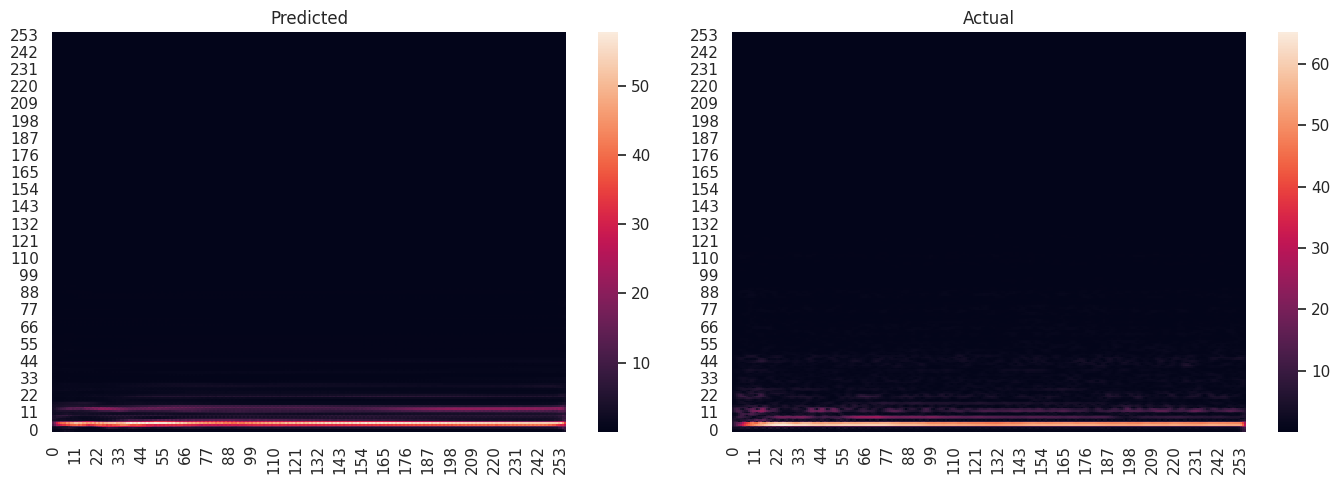

In [8]:
plot_heatmaps(predictions[0], targets[0])

In [9]:
_, test_data_loader_phase = build_data_loaders(
    min_max, part="phase", test_size=test_size)
phases = get_phases(test_data_loader_phase,
                    instrument="ney",
                    limit=pred_limit)

08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------
08_Ney_Gs_3/chunk_12, 08_Ney_Gs_3/chunk_13, 08_Ney_Gs_3/chunk_14, 08_Ney_Gs_3/chunk_15
--------------------------------------------------
08_Ney_Gs_3/chunk_16, 08_Ney_Gs_3/chunk_17, 08_Ney_Gs_3/chunk_18, 08_Ney_Gs_3/chunk_19
--------------------------------------------------
08_Ney_Gs_3/chunk_20, 08_Ney_Gs_3/chunk_21, 08_Ney_Gs_3/chunk_22, 08_Ney_Gs_3/chunk_23
--------------------------------------------------
08_Ney_Gs_3/chunk_24, 08_Ney_Gs_3/chunk_25, 08_Ney_Gs_3/chunk_26, 08_Ney_Gs_3/chunk_27
--------------------------------------------------
08_Ney_Gs_3/chunk_28, 08_Ney_Gs_3/chunk_29, 

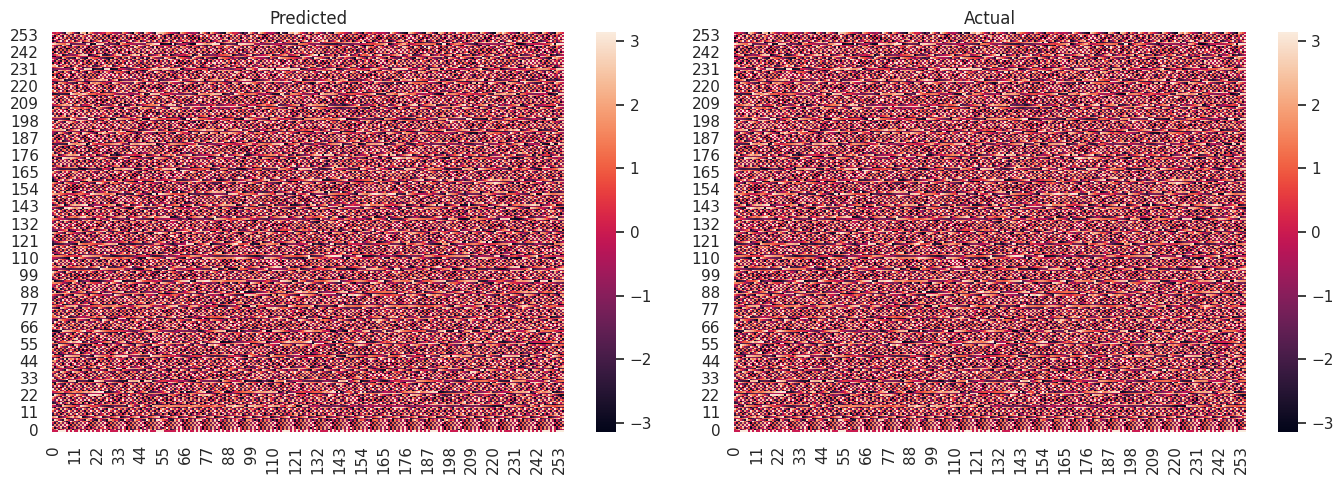

In [10]:
plot_heatmaps(phases[0], phases[0])

48064 48064


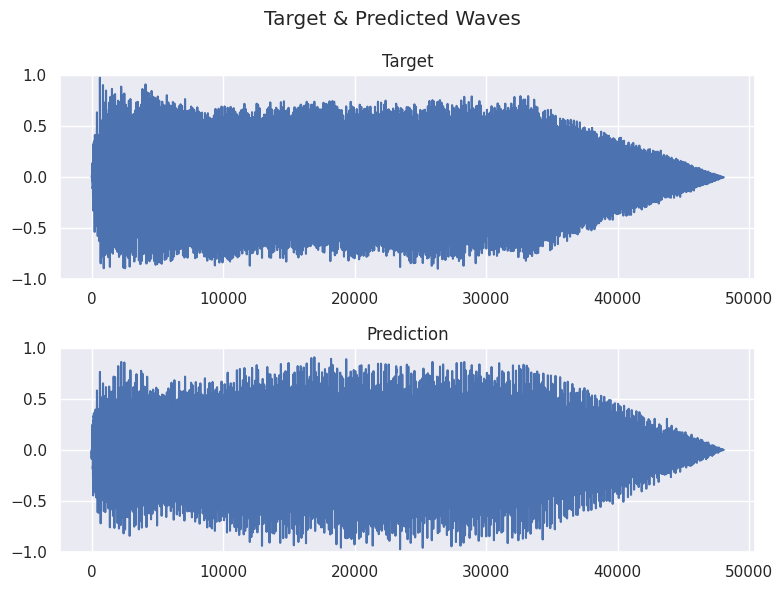

In [11]:
wave_prediction = make_wav(predictions, phases)
wave_target = make_wav(targets, phases)
print(len(wave_prediction), len(wave_target))
plot_waves(wave_target, wave_prediction)

In [ ]:
ipd.Audio(wave_target, rate=SR)

In [ ]:
ipd.Audio(wave_prediction, rate=SR)

In [14]:
sf.write("z_target.wav", wave_target, SR, format="wav")
sf.write("z_prediction.wav", wave_prediction, SR, format="wav")

In [13]:
save_model(model, "model_2_mag_2b_16feat")